In [14]:
import os
import pandas
import copy
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

<br/><br/><br/>
*Danny Weitekamp, Learning_Curves, GitHub repository:*
- [Learning_Curves](https://github.com/DannyWeitekamp/Learning_Curves)

In [2]:
def sliding_window(array, size = 3):
    res = np.zeros(len(array) - size + 1)
    for i in range(len(res)):
        res[i] = np.mean(array[i:(i+size)])
    return res

In [3]:
def generate_step_slices(x):
    outcomes = x['Outcome']
    last_correct = 0
    for row in range(x.shape[0]):
        if((outcomes[row]) == "CORRECT"):
            yield x[last_correct:row+1]
            last_correct = row+1

            
def generate_step_dicts(student_table, KC='KC (Field)',only_first_error=True):
    opportunity_counts = {}
    c = 0 
    for step_slice in generate_step_slices(student_table):
        c = c + 1
        step_name = step_slice[KC].iloc[-1]
        
        if(not isinstance(step_name,str) or step_name == ""):
            continue
        
        d = {}
        for _,table_row in step_slice.iterrows():
  
            if(str(table_row['Outcome']).strip().upper() == "INCORRECT"):
        
                d["general error"] = True
        
                if(table_row["error_type"] == "incorrect"):
                    d["incorrect"] = True

                elif(table_row['error_type'] == "misapplied"):
                    d["misapplied"] = True
                     
                elif(table_row['error_type'] == "out of graph"):  
                    d["out of graph"] = True
                    
                elif(table_row['error_type'] == "repeat"):  
                    d["repeat"] = True
                    
                elif(table_row['error_type'] == "when error"):  
                    d["when error"] = True    
                    
                elif(table_row['error_type'] == "where error"):  
                    d["where error"] = True 
                    
                elif(table_row['error_type'] == "wild error"):  
                    d["wild error"] = True 
            
                 
                    
            elif(str(table_row['Outcome']).strip().upper() == "HINT"):
                d["hint"] = True
                
            if(only_first_error):
                break
        d['KC'] = step_name 
        
        opportunity_counts[step_name] = opportunity_counts.get(step_name,0) + 1
        d['Opportunity'] = opportunity_counts[step_name]
        
        yield d

        
def increment_at_index(l,i,amount=0):
    if(i < len(l)):
        l[i] += amount
    elif(i == len(l)):
        l.extend([amount])
    else:
        raise ValueError("Nope", len(l), i)
        
                
def get_learning_curves(student_tables, KC='KC (Field)',only_first_error=True):
    kc_dict = {}
    kc_template = {"Counts": [], "Errors": [], "Incorrect": [], "Misapplied": [], "Out of graph" : [], "Repeat" :[], "When error":[], "Where error": [], "Wild error": [], "Hint error" : []}
    
    
    
    for st in student_tables:
        for sd in generate_step_dicts(st, KC=KC,only_first_error=only_first_error):
            kc_name = sd.get('KC',None)
            kc_data = kc_dict.get(kc_name, copy.deepcopy(kc_template))
            
            
            
            increment_at_index(kc_data["Counts"], sd["Opportunity"] -1, 1)
 
            inc, mis, out, rep, when, where, wild, h = sd.get('incorrect',False), sd.get('misapplied',False),sd.get('out of graph',False), sd.get('repeat',False), sd.get('when error',False), sd.get('where error',False), sd.get('wild error',False), sd.get('hint',False)  
            
            gen = sd.get('general error', False)
            
            
            op = sd["Opportunity"]
            indx = op-1
      
            increment_at_index(kc_data["Errors"], indx, 1 if inc or mis or out or rep or when or where or wild or h or gen else 0)
            
            increment_at_index(kc_data["Incorrect"], indx, 1 if inc else 0)
            
            increment_at_index(kc_data["Misapplied"], indx, 1 if mis else 0)
            
            increment_at_index(kc_data["Out of graph"], indx, 1 if out else 0)
            
            increment_at_index(kc_data["Repeat"], indx, 1 if rep else 0)
            
            increment_at_index(kc_data["When error"], indx, 1 if when else 0)
            
            increment_at_index(kc_data["Where error"], indx, 1 if where else 0)
            
            increment_at_index(kc_data["Wild error"], indx, 1 if wild else 0)
            
            increment_at_index(kc_data["Hint error"], indx, 1 if h else 0)
            
            kc_dict[kc_name] = kc_data
                    
    return kc_dict


def gen_student_tables(df, student_ID):
    student_tables = []
    student_tables.append(df[df['Anon Student Id'] == student_ID])
    return student_tables



def transaction_file_to_df(path):
    df = pandas.read_csv(path, lineterminator='\n', skip_blank_lines=True).replace({r'\r': ''}, regex=True)
    df = df.rename(index=str, columns={a:a.rstrip() for a in df.keys()})
    return df

            
def curves_from_transaction_file_one_student(df, stu, KC='KC (Field)', only_first_error=True):        
    df = transaction_file_to_df(df)          
    student_tables = gen_student_tables(df, stu)
    learning_curves_by_kc = get_learning_curves(student_tables, KC=KC,only_first_error=only_first_error)
    return learning_curves_by_kc
    

                
 




In [4]:
def add_counts(a,b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c


def aggregate_curves(d, selection=None):
    if(selection == None): selection = d.keys();
    print(selection)
    agg_curve = {}
    for (kc_name, kc) in d.items() :
        if(kc_name in selection):
            
            counts = np.array(kc['Counts'], dtype=np.float)
            errors = np.array(kc['Errors'], dtype=np.float)
            inc_errors = np.array(kc['Incorrect'], dtype=np.float)
            mis_errors = np.array(kc['Misapplied'], dtype=np.float)
            out_errors = np.array(kc['Out of graph'], dtype=np.float)
            rep_errors = np.array(kc['Repeat'], dtype=np.float)
            when_errors = np.array(kc['When error'], dtype=np.float)
            where_errors = np.array(kc['Where error'], dtype=np.float)
            wild_errors = np.array(kc['Wild error'], dtype=np.float)
            
            hint_errors = np.array(kc['Hint error'], dtype=np.float)
            
            
            
            
            
            agg_curve['Counts'] = add_counts(agg_curve.get('Counts',np.zeros(0)), counts)
            agg_curve['Errors'] = add_counts(agg_curve.get('Errors',np.zeros(0)), errors)
            agg_curve['Incorrect Errors'] = add_counts(agg_curve.get('Incorrect Errors',np.zeros(0)), inc_errors)
            agg_curve['Misapplied Errors'] = add_counts(agg_curve.get('Misapplied Errors',np.zeros(0)), mis_errors)
            agg_curve['Out of graph Errors'] = add_counts(agg_curve.get('Out of graph Errors',np.zeros(0)), out_errors)
            agg_curve['Repeat Errors'] = add_counts(agg_curve.get('Repeat Errors',np.zeros(0)), rep_errors)
            agg_curve['When Errors'] = add_counts(agg_curve.get('When Errors',np.zeros(0)), when_errors)
            agg_curve['Where Errors'] = add_counts(agg_curve.get('Where Errors',np.zeros(0)), where_errors)
            agg_curve['Wild Errors'] = add_counts(agg_curve.get('Wild Errors',np.zeros(0)), wild_errors)
            
            agg_curve['Hint Errors'] = add_counts(agg_curve.get('Hint Errors',np.zeros(0)), hint_errors)
    
            
    return agg_curve
            
    
def plot_sliding_window(name, student_path, student_name, size = 3):

    kc = aggregate_curves(curves_from_transaction_file_one_student(student_path, student_name))


    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
  #  print("kc looks like", kc)
    counts = np.array(kc['Counts'], dtype=np.float)
    error = np.array(kc['Errors'], dtype=np.float)/counts
    
    inc_error = np.array(kc['Incorrect Errors'], dtype=np.float)/counts
    mis_error = np.array(kc['Misapplied Errors'], dtype=np.float)/counts
    out_error = np.array(kc['Out of graph Errors'], dtype=np.float)/counts
    rep_error = np.array(kc['Repeat Errors'], dtype=np.float)/counts
    when_error = np.array(kc['When Errors'], dtype=np.float)/counts
    where_error = np.array(kc['Where Errors'], dtype=np.float)/counts  
    wild_error = np.array(kc['Wild Errors'], dtype=np.float)/counts
    
    
    hint_error = np.array(kc['Hint Errors'], dtype=np.float)/counts
    
    
    # sliding window
    error = sliding_window(error, size)
    inc_error = sliding_window(inc_error, size)
    mis_error = sliding_window(mis_error, size)
    out_error = sliding_window(out_error, size)
    rep_error = sliding_window(rep_error, size)
    when_error = sliding_window(when_error, size)
    where_error = sliding_window(where_error, size)
    wild_error = sliding_window(wild_error, size)
    hint_error = sliding_window(hint_error, size)
    len_error, len_inc, len_mis, len_out, len_rep, len_when, len_where, len_wild, len_hint = np.arange(len(error)), np.arange(len(inc_error)), np.arange(len(mis_error)), np.arange(len(out_error)), np.arange(len(rep_error)), np.arange(len(when_error)), np.arange(len(where_error)), np.arange(len(wild_error)), np.arange(len(hint_error))
    
    
    
    fig = plt.figure()
    
    plt.figure(figsize=(15,10))
    
    
    ax = plt.subplot(111)    
    
    ax.plot(len_error, error,  # marker="o",
            label='total error', color=colors['firebrick'])
    ax.plot(len_inc, inc_error, # marker="d", 
            label='incorrect error', color=colors['gold'])
    ax.plot(len_mis, mis_error, # marker="s",
            label='misapplied error', color=colors['green'])
    ax.plot(len_out, out_error, # marker="1" , 
            label='out of graph error', color=colors['dodgerblue'])
    ax.plot(len_rep, rep_error, # marker = 'p',
            label='repeat error', color=colors['gray'])
    ax.plot(len_when, when_error, # marker = '*',
            label='when error', color=colors['magenta'])
    ax.plot(len_where, where_error, # marker = 'D',
            label='where error', color=colors['orange'])
    ax.plot(len_wild, wild_error, # marker = 'x', 
            label='wild error', color=colors['lightblue'])
    
    ax.plot(len_hint, hint_error, # marker = 'x', 
            label='hint error', color=colors['blueviolet'])
    
    
    ax.set_ylim([-0.01,1.025])  

    
    ax.legend()
    plt.title('KC: %s' % name)
    plt.ylabel('Error')



<br/><br/><br/><br/><br/><br/> 
### Plotting learning curves for individual student with sliding window
> To plot a graph for an individual student with sliding window , use 
**plot_sliding_window(*name*, *student_path*, *student_name*, *size = 3*)** 
<br/><br/>
> Parameters: 
- name - title of the graph
- student_path - a path for the log that contains transactions of the student 
- student_name - name of the individual student 
- size - size of the sliding window

> Example in cell below: 



dict_keys(['AD check_convert', 'AD den3', 'AD den4', 'AD num3', 'AD num4', 'AD num5', 'AD den5', 'AD done', 'M num5', 'M den5', 'M done', 'AS den5', 'AS num5', 'AS done'])
dict_keys(['M num5', 'M den5', 'M done', 'AS num5', 'AS den5', 'AS done', 'AD check_convert', 'AD den3', 'AD den4', 'AD num3', 'AD num4', 'AD den5', 'AD num5', 'AD done'])


<Figure size 432x288 with 0 Axes>

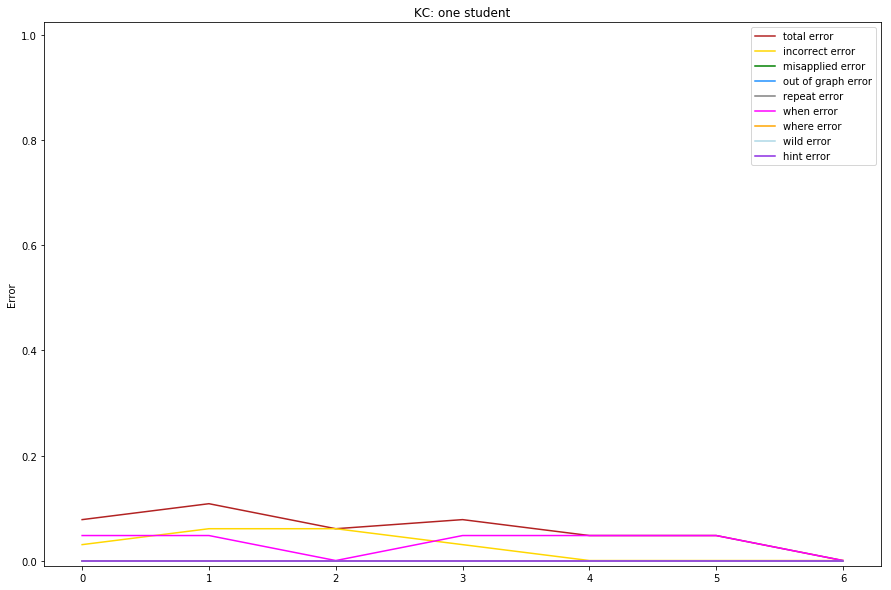

<Figure size 432x288 with 0 Axes>

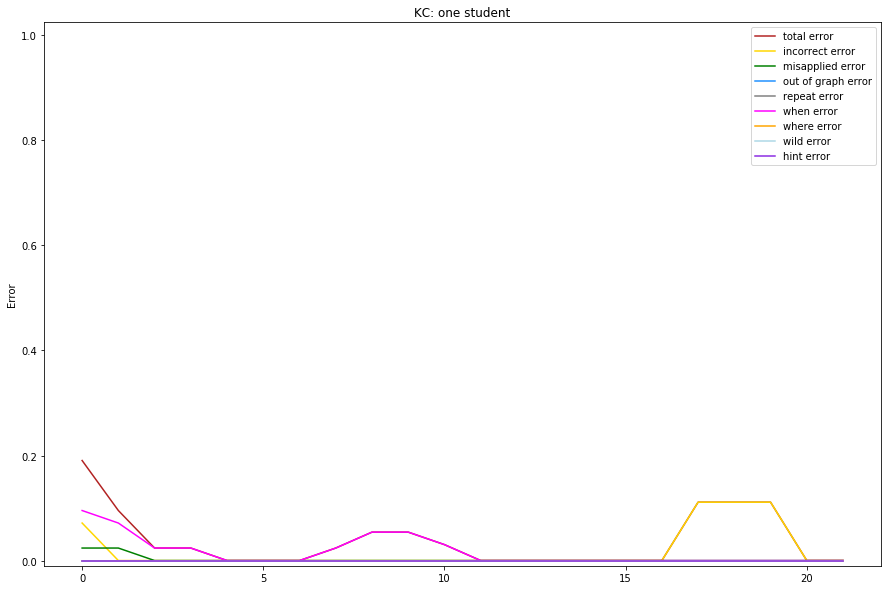

In [12]:
path_student = '/Users/daniellaye/Desktop/human_sai/duplicate.csv'
plot_sliding_window("one student", path_student, "Stu_45795cae7c16ce259633c256d58134b1", size = 3)
plot_sliding_window("one student", path_student, "Stu_fb2225ae05454b07d5dec8b159412859", size = 3)



